# Exercise 2
Reinforcement Learning Course, 2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from torch.utils.data import TensorDataset, DataLoader
import gym

import expert # local file to import expert controllers

%matplotlib inline

## Setup

Run pipenv inside project folder:

  > pipenv install

  > pipenv shell

## Helper Functions

In [2]:
def perform_rollout(env, controller, render=False, to_cpu=None, **controller_kwargs):
    if to_cpu:
        controller.cpu()
    obs = env.reset()
    traj_obs = []
    traj_acts = []
    traj_rewards = []
    for i in range(5000): # maximal task horizon (anyway limited by env)
        action = controller.predict(obs, **controller_kwargs)  # ask the controller (expert or network)
        if isinstance(action, tuple): # the expert policy returns a tuple (action, some_internals)
            action=action[0]
        traj_obs.append(obs)
        traj_acts.append(action)
        obs, reward, done, info = env.step(action)  # make a step in the environment
        traj_rewards.append(reward)
        if render:
            env.render()
        if done:  # this is the sign that the rollout ended
            break
    traj = {'observations' : np.asarray(traj_obs),
            'actions' : np.asarray(traj_acts),
            'rewards' : np.asarray(traj_rewards)
            }
    return sum(traj_rewards), traj

# Task 1: Training-data and Behavioral Cloning

load/create an environment

In [3]:
# env_name = "LunarLanderContinuous-v2"
# env = gym.wrappers.TimeLimit(gym.make(env_name),1000)

In [4]:
# Or the walker env (but us less rollouts here, otherwise slow)

In [5]:
env_name = "BipedalWalker-v3"
env = gym.wrappers.TimeLimit(gym.make(env_name),1500)

##  Run Expert

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
expert_controller = expert.load_expert(f"experts/ppo_{env_name}.zip", device=device)
number_runs = 20 # 50
trajectories = []
rewards = []
for r in range(number_runs):
    cum_reward, traj = perform_rollout(env, expert_controller, render=False, deterministic=True)
    # TODO: Complete here
    if cum_reward >= 100:
        trajectories.append(traj)
        rewards.append(cum_reward)
    
    # consider ignoring the rollouts where the expert is not good (reward < 100)
    
# make sure you keep the trajectories in "trajectories"
# and all the rewards for plotting

# if the rewards are in "rewards" you can print it this way
print(f"Expert performance {np.mean(rewards)} +- {np.std(rewards)}")

Expert performance 289.4233838407599 +- 1.9005936450063752


Lets look at it:

## convert trajectories into training data

In [8]:
def get_all_data_from_trajectories(trajectories):
    all_observations = np.concatenate([ t['observations'] for t in trajectories])
    all_actions = np.concatenate([ t['actions'] for t in trajectories])    
    print(f"{len(trajectories)} trajectories loaded: {len(all_observations)} transitions")
    return all_observations, all_actions

convert into training data for pytorch

In [9]:
expert_data = get_all_data_from_trajectories(trajectories)
num_data_points = len(expert_data[0])
# we split train and validation data (the last 10% of all data)
num_train = int(num_data_points * 0.9)
# conversion to PyTorch Tensors
x_train = torch.FloatTensor(expert_data[0][0:num_train])
y_train = torch.FloatTensor(expert_data[1][0:num_train])
x_validation = torch.FloatTensor(expert_data[0][num_train:])
y_validation = torch.FloatTensor(expert_data[1][num_train:])
# it is handy to use the DataLoader class that helps us to sample batches for training
train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=128)

20 trajectories loaded: 26477 transitions


## Define neural network

In [10]:
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_sizes  = hidden_sizes
        self.output_size  = output_size
        
        # TODO: complete here
        self.input = torch.nn.Linear(input_size, self.hidden_sizes[0])
        self.input_relu = torch.nn.ReLU()

        self.hidden_layers = torch.nn.ModuleList()
        for i in range(len(hidden_sizes)-1):
            self.hidden_layers.append(torch.nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.hidden_layers.append(torch.nn.ReLU())
        
        # the last layer (readout) shoud not contain a non-linearity: here is already the code for it:
        self.readout = torch.nn.Linear(self.hidden_sizes[-1], self.output_size)

    def forward(self, x):
        # TODO: write this
        x = self.input(x)
        x = self.input_relu(x)

        for hidden in self.hidden_layers:
            x = hidden(x)
        return self.readout(x)

    def predict(self, x):
        with torch.no_grad():
            return self.forward(torch.from_numpy(x.astype(np.float32))).numpy()

Setup the network and optimizer

In [11]:
model = Feedforward(x_train.shape[1], [100,50], y_train.shape[1])
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005, eps=0.00001)

Validation error before training

In [12]:
model.eval()  # put model in evaluation mode
with torch.no_grad():
    y_pred = model(x_validation)
    before_train = criterion(y_pred, y_validation)
    print('Validation error before training' , before_train.item())

Validation error before training 0.29915493726730347


In [13]:
model.train() # put model in training mode
epochs = 10 # try more

training_losses = []
validation_losses = []
for epoch in range(epochs):
    for i, data in enumerate(train_dataloader, 0):  # Sample a batch from the data and perform training
        inputs, labels = data
        optimizer.zero_grad()
        # Forward pass
        pred = model(inputs)
        # Compute Loss
        loss = criterion(pred, labels)
        # compute gradients and update
        loss.backward()
        optimizer.step()
    # Todo: evaluate training and validation errors and store them
    with torch.no_grad():
        y_pred = model(x_train)
        train = criterion(y_pred, y_train)
        training_losses.append(train.item())

        y_pred = model(x_validation)
        validation = criterion(y_pred, y_validation)
        validation_losses.append(validation.item())

    

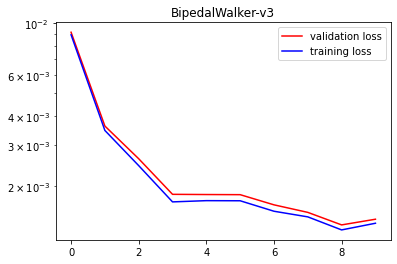

In [14]:
# # Todo: create a plot of the error over epochs
plt.plot(validation_losses, color='red', label='validation loss')
plt.plot(training_losses, color='blue', label='training loss')
plt.yscale('log')

plt.title(env_name)
plt.legend()
# and save it to
plt.savefig(f"{env_name}_bc_training.pdf")

# Test network as policy

In [15]:
# TODO: run the policy as controller for 50 rollouts for the LunarLander (20 or Walker)
# store rewards of all rollouts to do statistics later
model_rewards = []
for r in range(20):
    cum_reward, traj = perform_rollout(env, model, render=False) 
    model_rewards.append(cum_reward)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb2b044a550>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb2b044ab00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb2b044a2e8>,
 'medians': [<matplotlib.lines.Line2D at 0x7fb2b03f20f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb2b03f23c8>,
 'means': []}

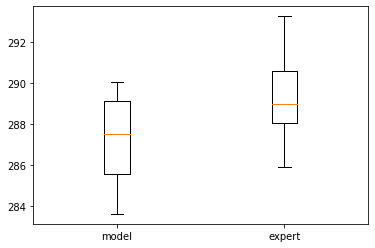

In [16]:
# consider making a box-plot with the rewards of the cloned network vs the expert
plt.boxplot([model_rewards, rewards], labels=['model', 'expert'])

# Task 2: Dagger

## Functions

For Dagger let us put all pieces into small functions

In [17]:
def rollout_policy_and_collect_data(env, policy, number_rollouts, render=False):
    # TODO: write this function: it should run the policy for number_rollouts times and return
    rewards = []
    trajectories = []
    for r in range(number_runs):
        cum_reward, traj = perform_rollout(env, model, render, True) 
        rewards.append(cum_reward)
        trajectories.append(traj)
    return np.asarray(rewards), trajectories

In [18]:
def relabel_actions(data, expert): # data is tuple of (all_observations, all_actions)
    # TODO: use the expert to create new action labels for the given data. Return the relabeled data
    relabeled_data = []
    new_actions = np.zeros(data[1].shape)
    
    for i, o in enumerate(data[0]):
        new_action = expert.predict(o)
        # print(new_action)
        new_actions[i] = new_action[0]
        
    return (data[0], new_actions)

In [19]:
def train_policy(model, train_dataloader, num_epochs, criterion, optimizer, device):
    # TODO: train the model/policy for the given number of epochs
    if device == 'cuda':
        model.cuda()
    model.train() # put model in training mode    
    
    training_losses = []
    validation_losses = []
    for epoch in range(epochs):
        for i, data in enumerate(train_dataloader, 0):  # Sample a batch from the data and perform training
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            # Forward pass
            pred = model(inputs)
            # Compute Loss
            loss = criterion(pred, labels)
            # compute gradients and update
            loss.backward()
            optimizer.step()

In [20]:
def data_to_trainloader(data):    
    x_train = torch.FloatTensor(data[0])
    y_train = torch.FloatTensor(data[1])    
    train_dataset = TensorDataset(x_train, y_train)
    return DataLoader(train_dataset, batch_size=128)

## Dagger -  Loop

In [21]:
dagger_performance = []
#prefill data with expert data
data = expert_data

In [22]:
model = Feedforward(x_train.shape[1], [100,50], y_train.shape[1])
model.cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005, eps=0.00001)

In [23]:
num_dagger_iter = 50 # 100
number_rollouts_per_iter = 5  # For the walker you can use 1 rollout only
number_training_epochs_per_iter = 5

for i in range(num_dagger_iter):
    #TODO: implement the main Dagger Loop
    print(f"Iteration {i}, train on: {len(data[0])}")
    
    train_dataloader = data_to_trainloader(data)
    train_policy(model, train_dataloader, number_training_epochs_per_iter, criterion, optimizer, device)
    # rollout policy 
    rewards, trajectories = rollout_policy_and_collect_data(env, model, number_rollouts_per_iter)
    dagger_performance.append(np.mean(rewards))
    
    # relabel data    
    relabeled_data = relabel_actions(get_all_data_from_trajectories(trajectories), expert_controller)

    # merge_data (already done for you)
    data = np.concatenate([data[0],relabeled_data[0]]), np.concatenate([data[1],relabeled_data[1]])

Iteration 0, train on: 26477
20 trajectories loaded: 26231 transitions
Iteration 1, train on: 52708
20 trajectories loaded: 27354 transitions
Iteration 2, train on: 80062
20 trajectories loaded: 22232 transitions
Iteration 3, train on: 102294
20 trajectories loaded: 26361 transitions
Iteration 4, train on: 128655
20 trajectories loaded: 25221 transitions
Iteration 5, train on: 153876
20 trajectories loaded: 28108 transitions
Iteration 6, train on: 181984
20 trajectories loaded: 27472 transitions
Iteration 7, train on: 209456
20 trajectories loaded: 28743 transitions
Iteration 8, train on: 238199
20 trajectories loaded: 27737 transitions
Iteration 9, train on: 265936
20 trajectories loaded: 27617 transitions
Iteration 10, train on: 293553
20 trajectories loaded: 26497 transitions
Iteration 11, train on: 320050
20 trajectories loaded: 27620 transitions
Iteration 12, train on: 347670
20 trajectories loaded: 27711 transitions
Iteration 13, train on: 375381
20 trajectories loaded: 27000 tra

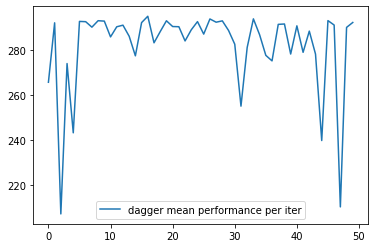

In [24]:
#TODO: plot mean performance per dagger iteration 
plt.plot(dagger_performance, label='dagger mean performance per iter')
plt.legend()
plt.savefig(f"{env_name}_dagger_training.pdf")

Let's look a the performance

Evaluation (no rendering)

In [26]:
dagger_rewards, _ = rollout_policy_and_collect_data(env, model, number_rollouts=50, render=False)
np.mean(dagger_rewards),np.std(dagger_rewards)

(292.572136988794, 1.6384546522594117)

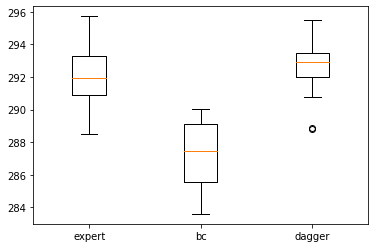

In [27]:
# put all three performance in a single boxplot (expert, bc, dagger)
plt.boxplot([rewards, model_rewards, dagger_rewards], labels=['expert', 'bc', 'dagger'])

plt.savefig(f"{env_name}_result.pdf")